In [2]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text

In [3]:
import getpass
password = getpass.getpass()

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

In [4]:
engine = create_engine('mysql+pymysql://root:' + password + '@localhost/sakila', echo=False, 
                       connect_args={'sql_mode': 'traditional'})

1 Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [5]:
# I'll extract titles for context and some other film info that I'll use later
query = '''SELECT film_id, title as movie_title, name as category, length as movie_length, rating, rental_duration
        FROM film
        LEFT JOIN inventory USING(film_id)
        LEFT JOIN film_category USING(film_id)
        LEFT JOIN category USING(category_id)
        LEFT JOIN rental USING(inventory_id)
        GROUP BY film_id;'''
df = pd.read_sql_query(query, engine)
df.head(5)

,film_id,movie_title,category,movie_length,rating,rental_duration
0,1,ACADEMY DINOSAUR,Documentary,86,PG,6
1,2,ACE GOLDFINGER,Horror,48,G,3
2,3,ADAPTATION HOLES,Documentary,50,NC-17,7
3,4,AFFAIR PREJUDICE,Horror,117,G,5
4,5,AFRICAN EGG,Family,130,G,6


2 Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [47]:
# I'll also add a column that counts the number of rentals in May
query = '''SELECT film_id, title as movie_title, category_id, length as movie_length, rating, rental_duration, IF(rental_date BETWEEN '2005-05-01' AND '2005-05-31', 1, 0) AS rented_in_may,
       (SELECT COUNT(*) FROM rental 
        WHERE inventory_id IN (SELECT inventory_id FROM inventory WHERE film_id = film.film_id) 
          AND rental_date BETWEEN '2005-05-01' AND '2005-05-31') AS rentals_in_may
        FROM film
        LEFT JOIN inventory USING(film_id)
        LEFT JOIN film_category USING(film_id)
        LEFT JOIN category USING(category_id)
        LEFT JOIN rental USING(inventory_id)
        GROUP BY film_id;'''
df = pd.read_sql_query(query, engine)
df.head()


,film_id,movie_title,category_id,movie_length,rating,rental_duration,rented_in_may,rentals_in_may
0,1,ACADEMY DINOSAUR,6,86,PG,6,0,2
1,2,ACE GOLDFINGER,11,48,G,3,0,0
2,3,ADAPTATION HOLES,6,50,NC-17,7,0,0
3,4,AFFAIR PREJUDICE,11,117,G,5,0,1
4,5,AFRICAN EGG,8,130,G,6,1,1


3 Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [75]:
df.shape

(1000, 8)

4 Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [48]:
df.dtypes

film_id             int64
movie_title        object
category_id         int64
movie_length        int64
rating             object
rental_duration     int64
rented_in_may       int64
rentals_in_may      int64
dtype: object

In [49]:
# I'll drop the movie_title column because I don't need it as I have the film_id
df.drop(columns=['movie_title'], inplace=True)

In [50]:
# Now I'll check for null values
df.isnull().sum()

film_id            0
category_id        0
movie_length       0
rating             0
rental_duration    0
rented_in_may      0
rentals_in_may     0
dtype: int64

<AxesSubplot:xlabel='rentals_in_may', ylabel='Count'>

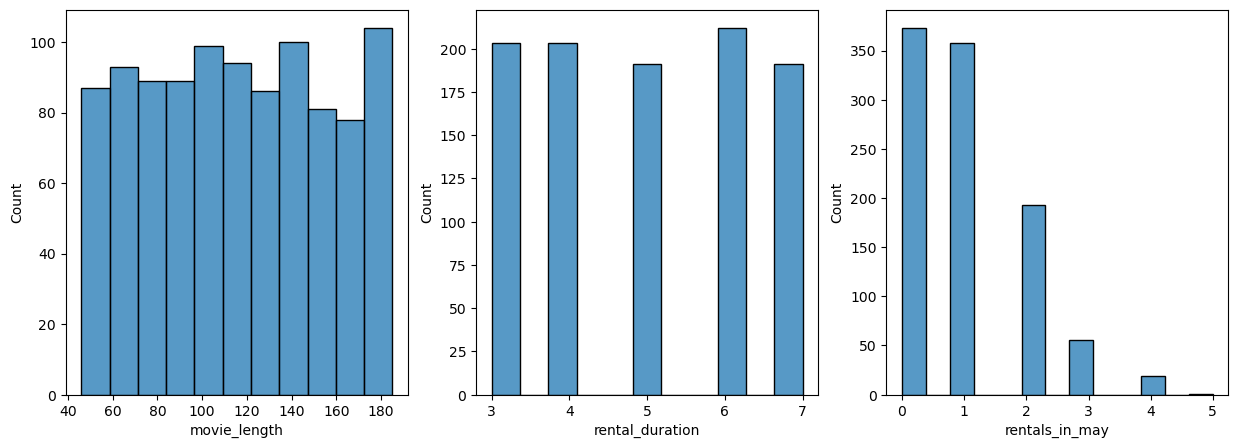

In [60]:
# Now let's check the distribution of the numeric variables to see if there are any outliers that need to be dealt with
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df['movie_length'], ax=axes[0])
sns.histplot(df['rental_duration'], ax=axes[1])
sns.histplot(df['rentals_in_may'], ax=axes[2])

In [61]:
# Before the transformations, let's define X & y
from sklearn.model_selection import train_test_split
y = df['rented_in_may']
X = df.drop(['rented_in_may'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Due to the small data set, let's go for a 70/30 split

In [62]:
# Split the data into train and test sets
X_train_num = X_train.select_dtypes(include=['int64']) 
X_test_num = X_test.select_dtypes(include=['int64'])
X_train_cat = X_train.select_dtypes(include=['object'])
X_test_cat = X_test.select_dtypes(include=['object'])

In [63]:
# We'll tranform the categorical variable ('rating') using one-hot encoding as it's ordinal 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
X_train_cat_encoded = encoder.transform(X_train_cat).toarray()
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoder.get_feature_names_out(X_train_cat.columns))
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=encoder.get_feature_names_out(X_test_cat.columns))

X_train_cat_encoded_df.head() # checking if it looks ok

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0


In [64]:
# Let's apply a MinMaxScaler to the numerical variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)

In [65]:
# Let's now concatenate the transformed numerical and categorical variables 
X_train_transformed = pd.concat([X_train_num_scaled_df, X_train_cat_encoded_df], axis=1)
X_test_transformed = pd.concat([X_test_num_scaled_df, X_test_cat_encoded_df], axis=1)

X_train_transformed.head()

,film_id,category_id,movie_length,rental_duration,rentals_in_may,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.541542,0.000000,0.043165,0.00,0.00,0.0,0.0,0.0,0.0
1,0.440440,0.333333,0.568345,0.50,0.00,0.0,0.0,1.0,0.0
2,0.482482,0.600000,0.899281,0.00,0.25,1.0,0.0,0.0,0.0
3,0.422422,0.133333,0.165468,1.00,0.00,0.0,1.0,0.0,0.0
4,0.778779,0.933333,0.057554,0.25,0.00,0.0,0.0,0.0,1.0


5 Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [66]:
from sklearn.linear_model import LogisticRegression

lrclassifier = LogisticRegression(random_state=0 , solver='lbfgs') 
lrclassifier.fit(X_train_transformed, y_train)
y_pred = lrclassifier.predict(X_test_transformed)

6 Evaluate the results.

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score 

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Kappa: ', cohen_kappa_score(y_test, y_pred))

Accuracy:  0.8366666666666667
Precision:  0.5
Recall:  0.14285714285714285
F1:  0.22222222222222224
Kappa:  0.1613418530351437


In [68]:
# Let's check the report per class 
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       251
           1       0.50      0.14      0.22        49

    accuracy                           0.84       300
   macro avg       0.68      0.56      0.57       300
weighted avg       0.80      0.84      0.80       300



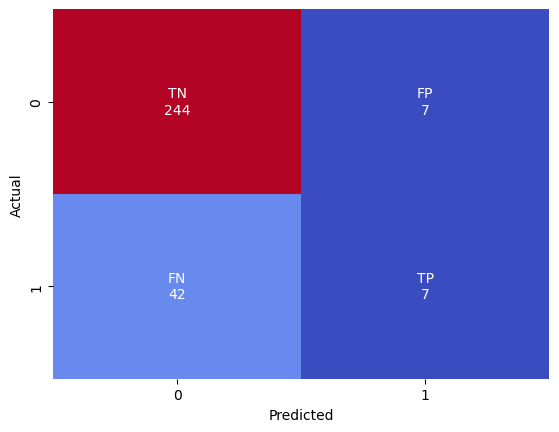

In [69]:
# Let's see this in a confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

labels = np.array([['TN', 'FP'], ['FN', 'TP']])
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f'{labels[i, j]}\n{cm[i, j]}'


sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# The model is not all that good 
# Maybe just having number of rentals in May is not enough, the dataset is too small

In [77]:
coef_list = list(zip(X_train_num_scaled_df.columns, lrclassifier.coef_[0]))

coef_df = pd.DataFrame(coef_list, columns=['Feature', 'Coefficient'])
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df_sorted)


           Feature  Coefficient
4   rentals_in_may     3.470132
0          film_id     0.392937
1      category_id     0.147361
3  rental_duration     0.038968
2     movie_length    -0.229337


In [ ]:
# In any case, we can see that the film name (film_id) is the most important feature in predicting whether a film will be rented in May or not. 
# (we'll ignore 'rentals_in_may' as it's of course correlated with 'rented_in_may')